In [1]:
import msprime as msp
import numpy as np
from numpy.linalg import matrix_rank
import cvxpy as cp
from datetime import datetime
import matplotlib.pyplot as plt

In [14]:
def generate_data(n, recombination_rate, seq_l, uniq_vals, l):
    sims = msp.simulate(sample_size=n,
                        mutation_rate=1e-8,
                        recombination_rate=recombination_rate,
                        Ne=2e4,
                        length=seq_l)
    pairs = [(i, j) for i in range(n) for j in range(n) if i < j]
    nc2 = len(pairs)
    mat = np.empty((nc2, seq_l))
    begin = 0
    for tree in sims.trees():
        end = int(tree.interval[1])
        tmrcas = np.array([tree.get_tmrca(i, j) for i, j in pairs])
        mat[:,begin:end] = np.tile(tmrcas, (end-begin,1)).T
        begin = end

    M = np.rint(np.repeat(np.unique(mat, axis=1)[:,:uniq_vals], l/uniq_vals, axis=1))
    dims = M.shape

    return (M, dims)

num_sims = 1
n = 15
recombination_rate = 1e-7
seq_l = 10000
uniq_vals = 10
l = 250

D1 = np.identity(l)
neg_ones = np.repeat(-1,l-1)
D2 = np.diag(neg_ones, 1)
D = np.delete(D1 + D2, l-1, 0)

#p_grid = np.arange(0.1, 1, 0.1)
p_grid = np.array([0.8])
num_p = p_grid.size
lambda_grid = np.array([0, 10])
num_lambda = lambda_grid.size

error_mat = np.empty((num_lambda+1, num_p, num_sims))
incorrect_guesses = np.empty((num_lambda+1, num_p, num_sims))

start = datetime.now()
lambda_10_list = []
lambda_0_list = []
fusion_list = []
for i in range(num_sims):

    while True:
        M, dims = generate_data(n, recombination_rate, seq_l, uniq_vals, l)
        if matrix_rank(M) == 10:
            break
    num_entries = dims[0] * dims[1]
    M_total = np.sum(M)

    for j in range(num_p):
        p = p_grid[j]
        Omega = np.ones(num_entries)
        Omega[:int(num_entries * p)] = 0
        Omega = np.random.permutation(Omega).reshape(dims)

        for k in range(num_lambda):
            lam = lambda_grid[k]

            X = cp.Variable(dims)
            objective = cp.Minimize(cp.norm(X, "nuc") + (lam * cp.pnorm(D @ X.T, 1)))
            constraints = [cp.multiply(Omega, M) == cp.multiply(Omega, X)]
            prob = cp.Problem(objective, constraints)
            prob.solve()
            error = (np.absolute(X.value - M)).sum()
            error_mat[k,j,i] = error
            incorrect_guesses[k,j,i] = np.sum(np.rint(X.value) != M)
            if lam == 10:
                lambda_10_list.append(X.value)
            else:
                lambda_0_list.append(X.value)
        
        X = cp.Variable(dims)
        objective = cp.Minimize(cp.pnorm(D @ X.T, 1))
        constraints = [cp.multiply(Omega, M) == cp.multiply(Omega, X)]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        error = (np.absolute(X.value - M)).sum()
        error_mat[k+1,j,i] = error
        incorrect_guesses[k+1,j,i] = np.sum(np.rint(X.value) != M)
        fusion_list.append(X.value)

In [15]:
print(np.sum(incorrect_guesses, axis=2)/(105*500))

[[0.40952381]
 [0.0255619 ]
 [0.04386667]]


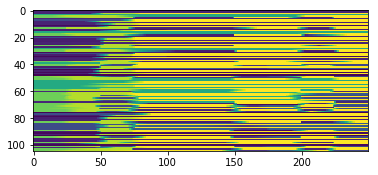

In [16]:
plt.imshow(fusion_list[0])

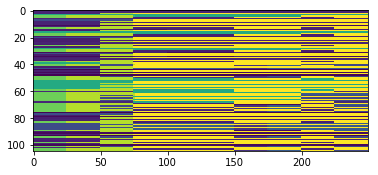

In [17]:
plt.imshow(lambda_10_list[0])

In [16]:
print(np.rint(X_lambda0[1,:]))

[28302. 28293. 28287. 28329. 28310. 27950. 28114. 28356. 28382. 28460.
 28132. 28329. 28286. 28118. 28465. 28502. 28444. 28362. 28329. 28417.
 28283. 28132. 28329. 27274. 28251. 28220. 28056. 28192. 28250. 28329.
 28254. 28329. 28329. 28229. 28491. 28347. 28359. 28329. 28190. 28372.
 28166. 28289. 28080. 28336. 28353. 28192. 28265. 28329. 28189. 28304.
 28258. 28329. 28384. 28342. 28388. 28246. 28248. 28329. 28239. 28096.
 28248. 28329. 28493. 28318. 28295. 28309. 28280. 28329. 28329. 28329.
 28346. 28634. 28377. 28329. 28445. 28387. 28461. 28471. 28647. 28316.
 28177. 28310. 28601. 28444. 28329. 28508. 28571. 28319. 28263. 28314.
 28164. 28162. 28458. 28135. 28248. 28365. 28511. 28329. 28132. 28761.
 28329. 28153. 28409. 28316. 28212. 28278. 28329. 28527. 28293. 27828.
 28329. 28327. 27977. 28235. 28153. 28329. 28228. 28329. 28329. 26578.
 28485. 28329. 28406. 28329. 28226. 28404. 28453. 28236. 28329. 28431.
 28311. 28370. 28280. 28064. 28236. 28445. 28108. 28222. 28329. 28324.
 28329